Info-284 Group exam
Group members: Heejung Yu, Tsz Ching, Sverre-Emil and Aaron Male

# Table of Contents
1. [Introduction](#Introduction)
2. [Preprocessing](#Preprocessing)
    - [Features](#Features)
        - [Species](#Species)
        - [Equipment](#Equipment)
        - [Gross Weight of Catch](#Gross-Weight-of-Catch)
        - [Boat Information](#Boat-Information)
        - [Location of Trip](#Location-of-Trip)
        - [Drag Distance](#Drag-Distance)
        - [Duration](#Duration)
        - [Time](#Time)
    - [Analyzation](#Analyzation)
        - [Hovedart FAO](#Hovedart-FAO)
        - [Lengdegruppe](#Lengdegruppe)
        - [Redskap FAO](#Redskap-FAO)
        - [Rundvekt](#Rundvekt)
3. [Supervised Learning](#Supervised-Learning)
    - [Picking the Machine Learning Models](#Picking-the-Machine-Learning-Models)
        - [K-NN](#k-NN)
        - [Linear Models](#Linear-Models)
        - [Naive Bayes](#Naive-Bayes)
        - [Decision Trees](#Decision-Trees)
        - [Ensembles of Decision Trees](#Ensembles-of-Decision-Trees)
        - [Neural Networks](#Neural-Networks)
    - [Our Choices](#Our-Choices)
4. [Unsupervised Learning](#unsupervised-learning)
    - [Preprocessing for Unsupervised Learning](#preprocessing-for-unsupervised-learning)
    - [Picking the Machine Learning Models for Unsupervised Learning](#picking-the-machine-learning-models-for-unsupervised-learning)
      - [Two Kinds of Unsupervised Learning Algorithms](#two-kinds-of-unsupervised-learning-algorithms)
      - [Picking a Clustering Algorithm](#picking-a-clustering-algorithm)
    - [Clustering with DBSCAN](#-clustering-with-dbscan)
      - [Looking into the Influence of the Values of Parameters](#looking-into-the-influence-of-the-values-of-parameters)
      - [Is the Largest Cluster Related to Bycatch?](#is-the-largest-cluster-related-to-bycatch?)
        - [Find a Relationship with Bycatch and Make a Confusion Matrix](#find-a-relationship-with-bycatch-and-make-a-confusion-matrix)
      -[Reflection on Unsupervised Learning](#reflection-on-unsupervised-learning)

## Introduction
After taking a quick look at the dataset and the documents that was provided with it, we figured we wanted to try to predict if an entry is a Bycatch. We believe that by being able to predict Bycatch we can find out if there are any boats that are misreporting their catches. We classify an entry as a Bycatch if the "Hovedart FAO" does not match with "Art FAO". We are aware this definition of a Bycatch is somewhat limited especially considering the way "Hovedart FAO" is chosen, ideally we would like to classify Bycatch as non-intended catches. However, this is hard to do without information about the fishing vessel's objectives prior to departure.

In [1]:
import warnings # Got an irritating warning
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)
pd.set_option('float_format', '{:f}'.format)

In [2]:
dataset = pd.read_csv("/content/elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv", sep = ";")
# Dataset where the species isn't the same as the main-species
bycatch = dataset[dataset['Art FAO'] != dataset['Hovedart FAO']]
main_species = dataset[dataset['Art FAO'] == dataset['Hovedart FAO']]

## Preprocessing

### Picking features
When choosing features to use from the dataset, we divided the 45 different columns into 8 different categories.
<br>
<br>
The 8 categories are as follows:
<ul>
<li>Species</li>
<li>Equipments used</li>
<li>Gross weight of catch</li>
<li>Boat information</li>
<li>Location of trip</li>
<li>Drag distance</li>
<li>Duration</li>
<li>Time</li>
</ul>

We chose to use the following features in our ML model: art, hovedart, redskap, rundvekt, lengdegruppe, hovedområde.

Our methodology in picking the features was first seeing how the data could be relevant for our prediction, we then plotted the data from each feature into various graphs to see the distribution and also looked at the relationship between one feature and the other.

#### Species

This feature consisted mainly of "Hovedart FAO" and "Art FAO", this feature is a necessity as it is used to check if the species is classified as a Bycatch or not.

#### Equipments

How can we measure the usefulness of equipments when predicting Bycatch? We checked the distribution of equipments in the original dataset and compared it with the Bycatch dataset.

<Axes: xlabel='Redskap FAO'>

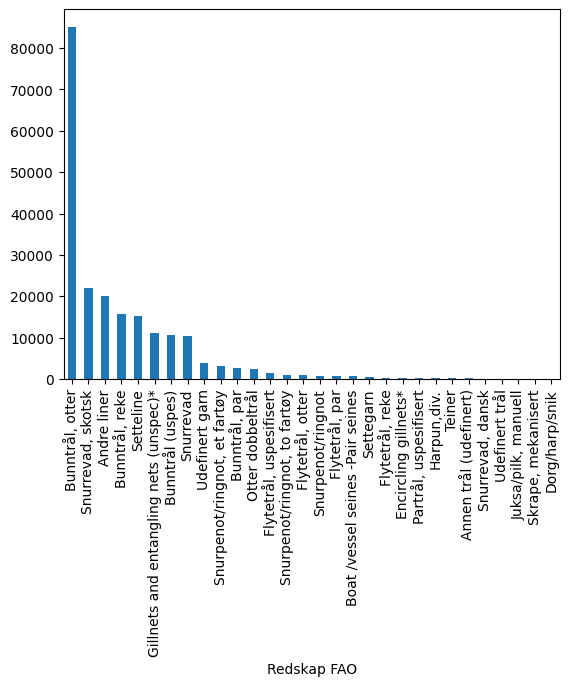

In [3]:
# A count of instances of equipment used for every Bycatch.
count_of_equipment_used_for_only_Bycatch = bycatch.groupby(["Redskap FAO"])["Redskap FAO"].count()
count_of_equipment_used_for_only_Bycatch = count_of_equipment_used_for_only_Bycatch.sort_values(ascending=False)
count_of_equipment_used_for_only_Bycatch.plot(kind="bar")

<Axes: xlabel='Redskap FAO'>

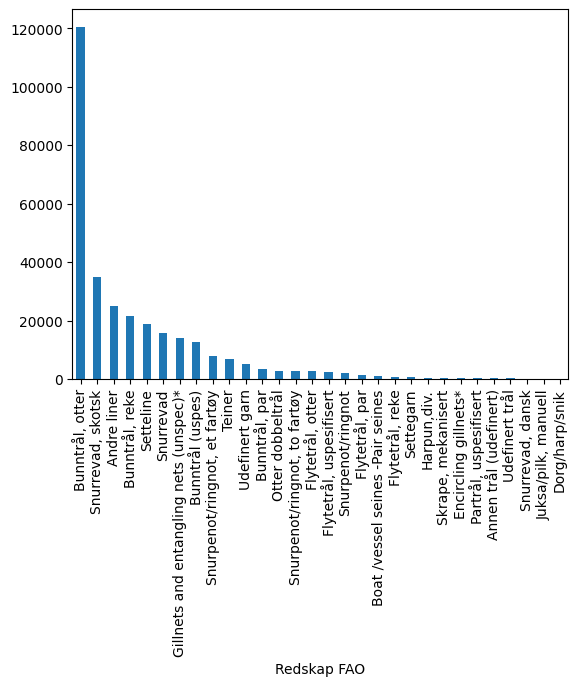

In [4]:
# A count of instances of equipment used for every species.
count_of_equipment_used_for_original_dataset = dataset.groupby(["Redskap FAO"])["Redskap FAO"].count()
count_of_equipment_used_for_original_dataset = count_of_equipment_used_for_original_dataset.sort_values(ascending=False)
count_of_equipment_used_for_original_dataset.plot(kind="bar")

Although there were a few difference in the distribution, the Bycatch dataset had a more noticeable sections whereas the original dataset had a steady decline. We didn't find there were too much of a difference between the two, and were unsure if it was relevant. So we tried another approach, we checked the correlation between the most common Bycatch species and their equipment.

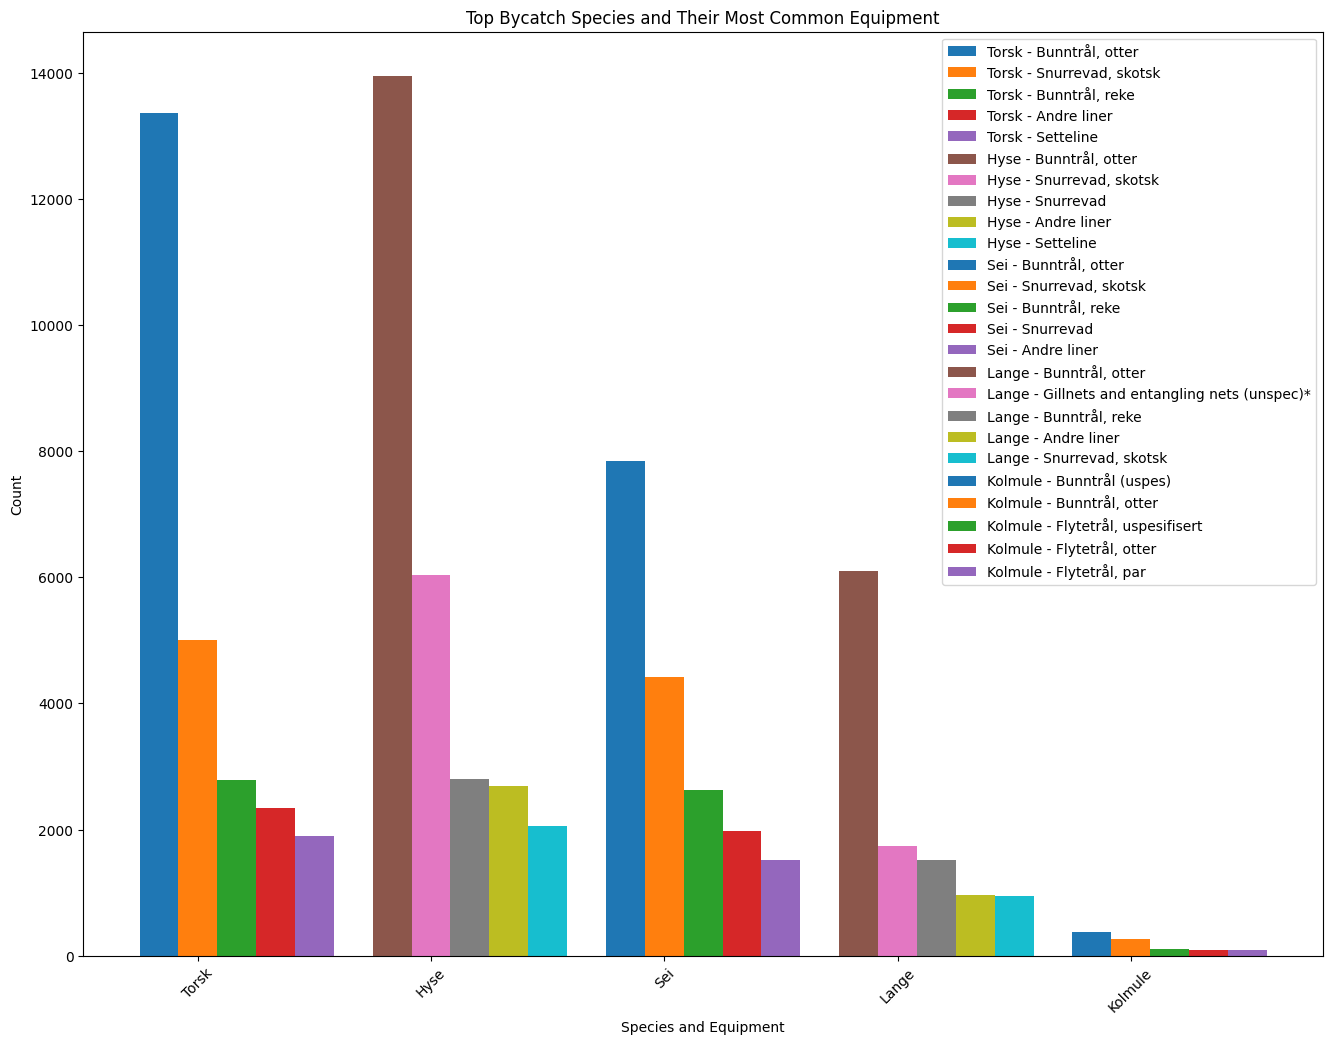

In [5]:



# Finding the most common bycatch, defined by Bycatch species with highest roundweight.
count_of_Bycatches_for_every_main_species = bycatch.groupby(["Art FAO"])["Rundvekt"].sum()

# Top 5 species
top_5_common_bycatch = (count_of_Bycatches_for_every_main_species.sort_values(ascending=False))[:5]
top_5_common_bycatch = list(top_5_common_bycatch.index)

fig, ax = plt.subplots(figsize=(16, 12))

positions = np.arange(len(top_5_common_bycatch))*3
width = 0.5

# Finding the most common equipment used for catching each of these species
for i, species in enumerate(top_5_common_bycatch):
    species_only_dataset = bycatch[bycatch["Art FAO"] == species]
    count_of_equipment_used = species_only_dataset.groupby("Redskap FAO")["Redskap FAO"].count()
    top_equipment_for_species = count_of_equipment_used.sort_values(ascending=False).head(5)

    for j, equipment in enumerate(top_equipment_for_species.index):
        ax.bar(positions[i] + j*width, top_equipment_for_species[equipment], width, label=f'{species} - {equipment}')

ax.set_xlabel('Species and Equipment')
ax.set_ylabel('Count')
ax.set_title('Top Bycatch Species and Their Most Common Equipment')

ax.set_xticks(positions + width)
ax.set_xticklabels(top_5_common_bycatch)

plt.legend()
plt.xticks(rotation=45)
plt.show()

Here we see that the distribution of most common equipment used for each species varies a lot, although the top equipments for the species are the same, the rest of the equipments varies.

#### Gross weight of catch

This one is relevant because of the way main species is calculated; "Main species caught, reported using the FAO species code. Main species is chosen using highest estimated weight in round kilograms." (datadokumentasjon-ers-rapport-varnivaa-5-140121, p.11) This means that the main species caught on average will be higher than if it were a Bycatch.  


#### Boat information

We chose to use Length group because the data in this feature is already categorized which makes it easier to process and use. We believe that the boat size is relevant when we use it together with equipments as we believe bigger boats use trawl equipments more often. We checked the distribution of equipments for every boat size.

In [6]:
every_lengthgroup = ["28 m og over", "21-27,99 m", "15-20,99 m"]

for length_group in every_lengthgroup:
        lengdegruppe_dataset = dataset[dataset["Lengdegruppe"] == length_group]
        lengdegruppe_equipmentcount = lengdegruppe_dataset.groupby([lengdegruppe_dataset["Redskap FAO"]])["Redskap FAO"].count()
        lengdegruppe_equipmentcount.sort_values(ascending=False, inplace=True)
        print(f"Top 3 common equipment for boats in category: {length_group}\n{lengdegruppe_equipmentcount.head(3)}\n")

Top 3 common equipment for boats in category: 28 m og over
Redskap FAO
Bunntrål, otter      102895
Andre liner           24054
Snurrevad, skotsk     17463
Name: Redskap FAO, dtype: int64

Top 3 common equipment for boats in category: 21-27,99 m
Redskap FAO
Bunntrål, otter      13202
Snurrevad, skotsk    11134
Bunntrål, reke       10051
Name: Redskap FAO, dtype: int64

Top 3 common equipment for boats in category: 15-20,99 m
Redskap FAO
Setteline            7639
Snurrevad, skotsk    6428
Bunntrål, reke       5689
Name: Redskap FAO, dtype: int64



We see that the distribution of equipments used in bigger boats is much more skewed towards trawls than the distribution in smaller boat. Therefore we believe that bigger boats are more likely to result in Bycatch.

#### Location of trip

To check if the area is relevant we chose to look at a Bycatch and main species dataset for torsk (Because it is the most common species). We compared the areas where they were caught as a Bycatch and where they were caught as the main species.

In [7]:
torsk_only = dataset[dataset['Art FAO'] == "Torsk"]
torsk_only_Bycatch = torsk_only[torsk_only['Hovedart FAO'] != "Torsk"]
torsk_only_main = torsk_only[torsk_only['Hovedart FAO'] == "Torsk"]

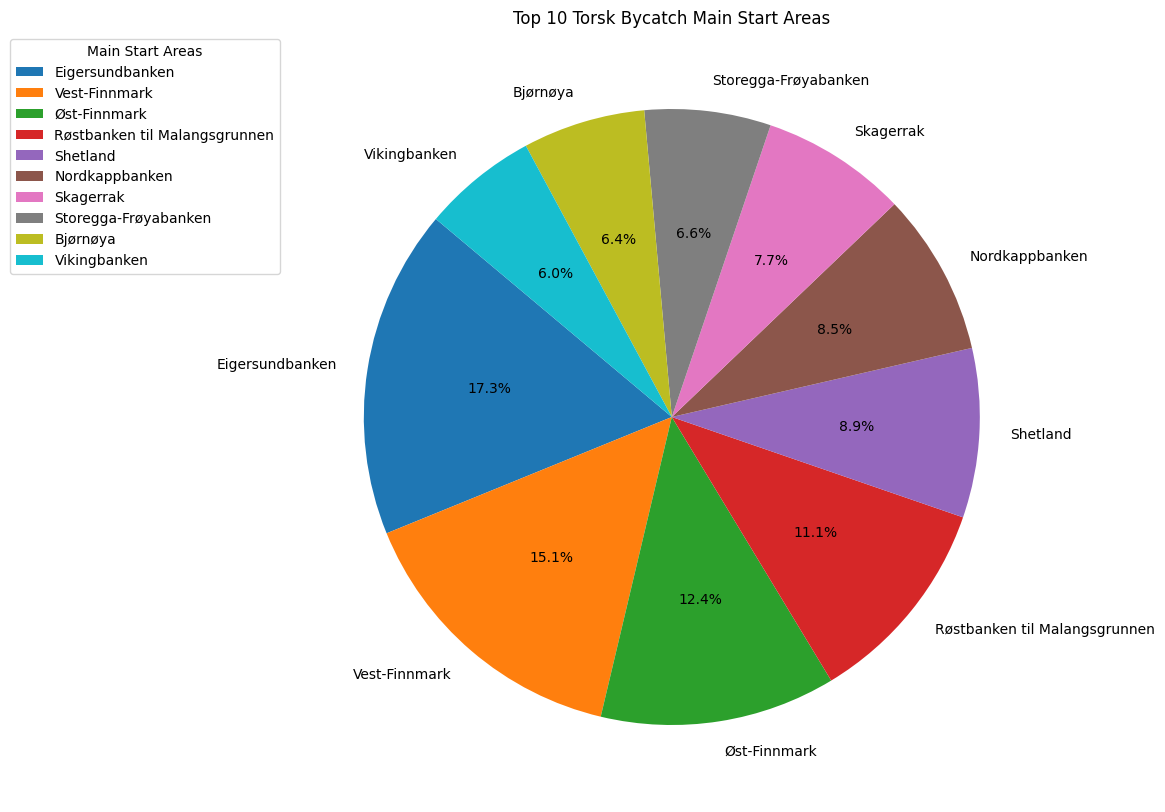

In [8]:

# Count the occurrences of each unique value in 'Hovedområde start', sort, and select top 10
top_10_areas_bycatch_start = torsk_only_Bycatch['Hovedområde start'].value_counts().head(10)

# Plot the top 10 areas
top_10_areas_bycatch_start.plot(kind='pie', figsize=(12, 10), fontsize=10, autopct='%1.1f%%', startangle=140)

plt.title('Top 10 Torsk Bycatch Main Start Areas', fontsize=12)
plt.ylabel('')
plt.legend(title='Main Start Areas', loc='upper right', bbox_to_anchor=(0, 1))
plt.show()


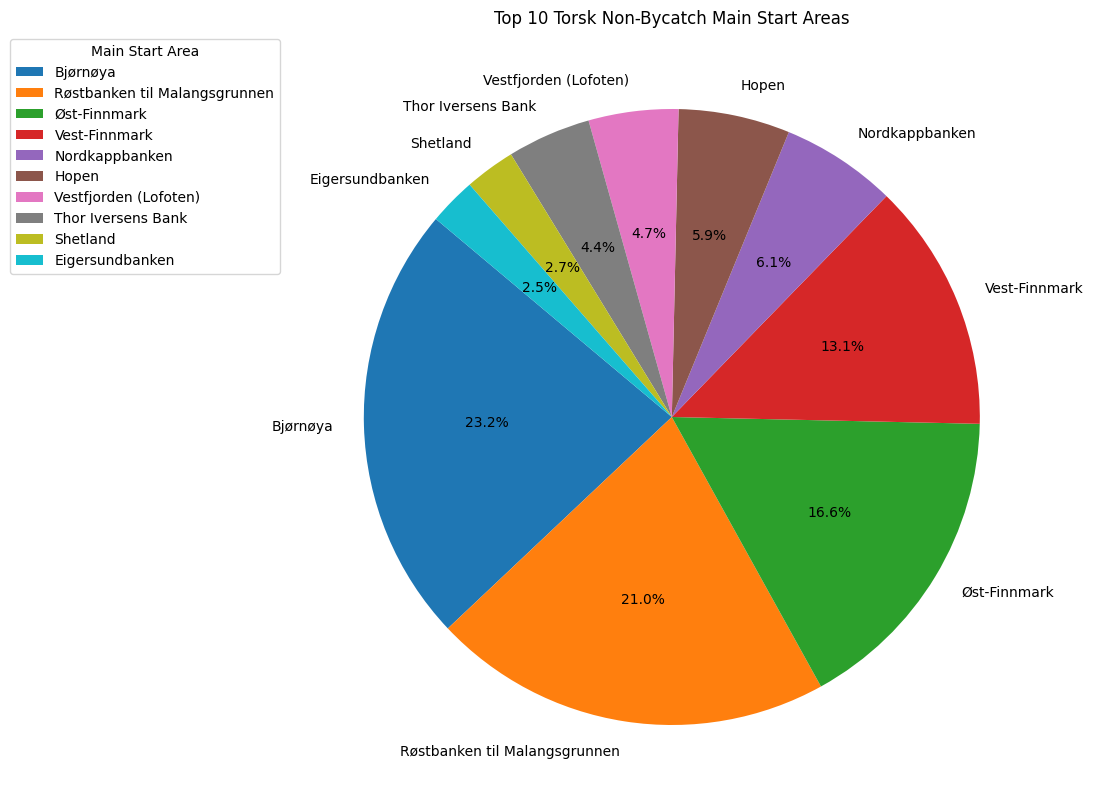

In [9]:

# Count the occurrences of each unique value in 'Hovedområde start', sort, and select top 10
top_10_areas = torsk_only_main['Hovedområde start'].value_counts().head(10)

# Plot the top 10 areas
top_10_areas.plot(kind='pie', figsize=(12, 10), fontsize=10, autopct='%1.1f%%', startangle=140)

plt.title('Top 10 Torsk Non-Bycatch Main Start Areas', fontsize=12)
plt.ylabel('')
plt.legend(title='Main Start Area', loc='upper right', bbox_to_anchor=(0, 1))
plt.show()

There is interestingly a big difference where the fish is caught when we compare Bycatch with main species.

#### Drag distance

To check if drag distance is relevant when predicting Bycatch we just took a quick look and compared values.


In [10]:
print("Duration for original dataset:\n", dataset["Trekkavstand"].describe())
print("\n")
print("Duration for bycatch:\n",bycatch["Trekkavstand"].describe())

Duration for original dataset:
 count     305410.000000
mean       15663.968262
std        90330.847329
min            0.000000
25%         2533.000000
50%         7598.000000
75%        22599.000000
max     15888632.000000
Name: Trekkavstand, dtype: float64


Duration for bycatch:
 count     210114.000000
mean       16815.527666
std        87925.570696
min            0.000000
25%         2790.000000
50%         9063.000000
75%        25190.000000
max     15888632.000000
Name: Trekkavstand, dtype: float64


Doesn't look like there is anything special here, maybe we can check drag distance for torsk when a specific equipment is used? We used the most common equipment for catching torsk: Bunntrål

In [11]:
torsk_only_dragdistance = dataset[dataset["Art FAO"] == "Torsk"]
# Removing an outlier so its easier to read the graph
torsk_only_dragdistance = torsk_only_dragdistance[torsk_only_dragdistance["Trekkavstand"] < 200000]

torsk_as_Bycatch_dragdistance = torsk_only_dragdistance[torsk_only_dragdistance["Hovedart FAO"] != "Torsk"]
torsk_as_Bycatch_dragdistance = torsk_as_Bycatch_dragdistance[torsk_as_Bycatch_dragdistance["Redskap FAO"] == "Bunntrål, otter"]


torsk_as_main_dragdistance = torsk_only_dragdistance[torsk_only_dragdistance["Hovedart FAO"] == "Torsk"]
torsk_as_main_dragdistance = torsk_as_main_dragdistance[torsk_as_main_dragdistance["Redskap FAO"] == "Bunntrål, otter"]

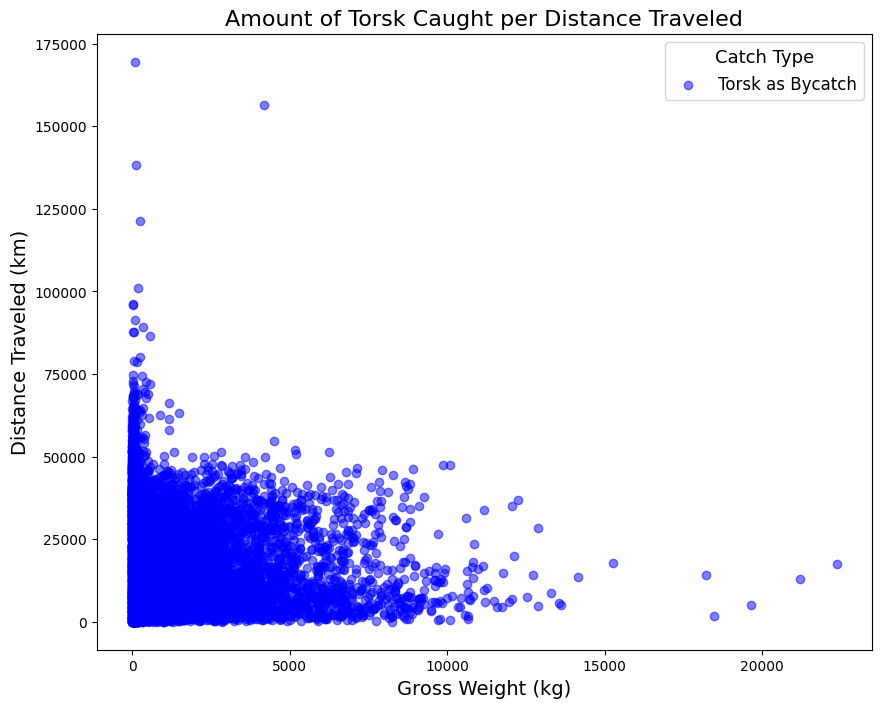

In [12]:
plt.figure(figsize=(10, 8))

# Scatter plot for bycatch
plt.scatter(torsk_as_Bycatch_dragdistance["Rundvekt"], torsk_as_Bycatch_dragdistance["Trekkavstand"], color='blue', alpha=0.5, label='Torsk as Bycatch')

# Adding labels and title
plt.xlabel("Gross Weight (kg)", fontsize=14)
plt.ylabel("Distance Traveled (km)", fontsize=14)
plt.title("Amount of Torsk Caught per Distance Traveled", fontsize=16)

# Adding a legend to distinguish between the two datasets
plt.legend(title="Catch Type", title_fontsize='13', fontsize='12')

# Show the plot
plt.show()

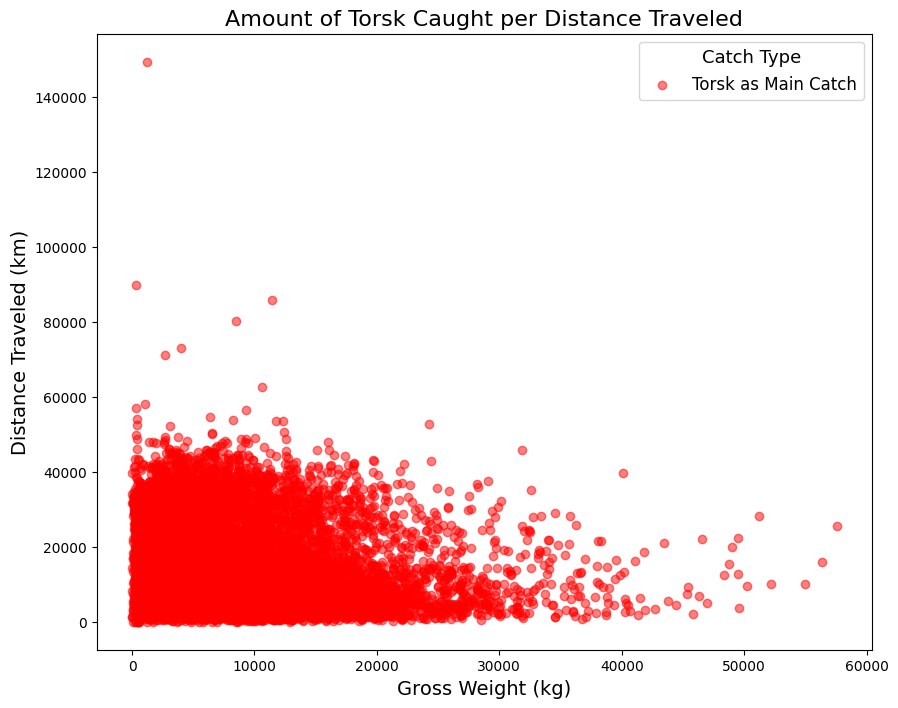

In [13]:
plt.figure(figsize=(10, 8))

# Scatter plot for main catch
plt.scatter(torsk_as_main_dragdistance["Rundvekt"], torsk_as_main_dragdistance["Trekkavstand"], color='red', alpha=0.5, label='Torsk as Main Catch')

# Adding labels and title
plt.xlabel("Gross Weight (kg)", fontsize=14)
plt.ylabel("Distance Traveled (km)", fontsize=14)
plt.title("Amount of Torsk Caught per Distance Traveled", fontsize=16)

# Adding a legend to distinguish between the two datasets
plt.legend(title="Catch Type", title_fontsize='13', fontsize='12')

# Show the plot
plt.show()

In [14]:
# amount of entries from 40 000 to 75 000 in Bycatch
filtered_dragdistance = torsk_as_Bycatch_dragdistance[(torsk_as_Bycatch_dragdistance["Trekkavstand"] > 40000) & (torsk_as_Bycatch_dragdistance["Trekkavstand"] < 75000)]

total_instances = filtered_dragdistance.shape[0]

print(total_instances)

815


Here we see that drag distance makes very little difference, most of the dots in the scatterplot is concentrated around 50-60k. while there are a bit fewer dots in the main species graph around 60k it is only 800 entries.

#### Duration

To check if duration is relevant when predicting Bycatch we just took a quick look and compared values.

In [15]:
print("Duration for original dataset:\n", dataset["Varighet"].describe())
print("\n")
print("Duration for bycatch:\n", bycatch["Varighet"].describe())

Duration for original dataset:
 count   305434.000000
mean       537.095526
std       2201.624688
min          0.000000
25%        123.000000
50%        296.000000
75%        494.000000
max     125534.000000
Name: Varighet, dtype: float64


Duration for bycatch:
 count   210128.000000
mean       414.088165
std        588.217837
min          0.000000
25%        138.000000
50%        306.000000
75%        547.000000
max     120906.000000
Name: Varighet, dtype: float64


As we can see the 25, 50 and 75 percentile are more or less the same, we believe this doesn't really help us predict Bycatch anyways.

#### Time

To see the relevance of time for our ml model, we can compare the start times of each fishing trip for torsk where the equipment used is the same.

In [16]:
torsk_only_Bycatch_bunntrål = torsk_only_Bycatch[torsk_only_Bycatch["Redskap FAO"] == "Bunntrål, otter"]
torsk_only_main_bunntrål = torsk_only_main[torsk_only_main["Redskap FAO"] == "Bunntrål, otter"]

# Convert columns to datetime format to extract the hour
torsk_only_Bycatch_bunntrål['Startklokkeslett'] = pd.to_datetime(torsk_only_Bycatch_bunntrål['Startklokkeslett'], format='%H:%M')
torsk_only_main_bunntrål['Startklokkeslett'] = pd.to_datetime(torsk_only_main_bunntrål['Startklokkeslett'], format='%H:%M')

# Extract the hour from the start time in both main and Bycatch dataframe
torsk_only_Bycatch_bunntrål['Startklokkeslett_time'] = torsk_only_Bycatch_bunntrål['Startklokkeslett'].dt.hour
torsk_only_main_bunntrål['Startklokkeslett_time'] = torsk_only_main_bunntrål['Startklokkeslett'].dt.hour

# counting hours
hourly_distribution_start = torsk_only_Bycatch_bunntrål['Startklokkeslett_time'].value_counts().sort_index()
hourly_distribution_start2 = torsk_only_main_bunntrål['Startklokkeslett_time'].value_counts().sort_index()

We chose to use a pie-chart because it visualizes the data better when we want to see percentage.

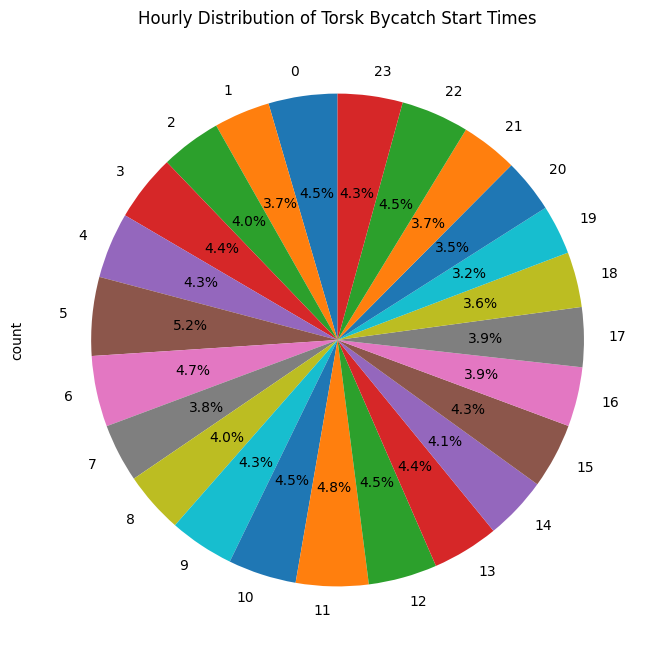

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
hourly_distribution_start.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Hourly Distribution of Torsk Bycatch Start Times')

plt.show()

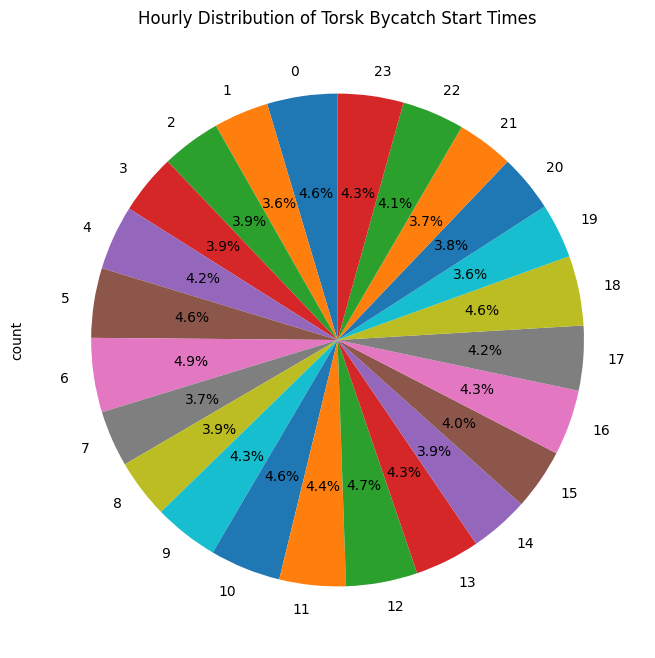

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
hourly_distribution_start2.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Hourly Distribution of Torsk Bycatch Start Times')

plt.show()

As we can see the start times for Bycatch and main species are basically the same, this makes us believe that it doesn't really matter when the fishing is done as it doesn't impact the statistics for Bycatch.

In [19]:
# Excluding all features that aren't relevant
dataset = dataset[["Hovedart FAO", "Art FAO", "Lengdegruppe", "Redskap FAO", "Rundvekt", "Hovedområde start"]]

### Analyzation
The primary objective of this analysis is to explore findings related to outliers within each chosen features of our dataset. By examining these outliers, we aim to understand their impact on the dataset and determine appropriate strategies for handling them. This process involves identifying outliers, assessing their significance, and deciding on actions such as keeping, modifying, or removing these outliers.
#### Hovedart FAO
Considering that "Hovedart FAO" will be the feature we use to identify if it is a Bycatch the only thing we have to consider are NaN values.

In [20]:
print(dataset["Hovedart FAO"].isna().sum())
print(dataset["Art FAO"].isna().sum())

# Drop all rows where Hovedart FAO and Art FAO is NaN
dataset = dataset.dropna(subset=["Hovedart FAO", "Art FAO"])

print(dataset["Hovedart FAO"].isna().sum())
print(dataset["Art FAO"].isna().sum())

4978
4982
0
0


Considering that this feature will be a vital part of our ml model we will be dropping all NaN values in this feature.

#### Lengdegruppe
Considering this feature is already categorized outliers aren't an issue here, we believe its only relevant to look at NaN values.


In [21]:
print(dataset["Lengdegruppe"].isna().sum())

lengdegruppe_is_NaN = dataset[(dataset["Lengdegruppe"].isna())]

pd.DataFrame(lengdegruppe_is_NaN.head(10))

683


Hovedart FAO   Art FAO Lengdegruppe         Redskap FAO      Rundvekt  \
347      Stortare  Stortare          NaN  Skrape, mekanisert 125000.000000   
939      Stortare  Stortare          NaN  Skrape, mekanisert 128000.000000   
1486     Stortare  Stortare          NaN  Skrape, mekanisert  93000.000000   
1512     Stortare  Stortare          NaN  Skrape, mekanisert 118000.000000   
1608     Stortare  Stortare          NaN  Skrape, mekanisert  80000.000000   
2260     Stortare  Stortare          NaN  Skrape, mekanisert  82000.000000   
2363     Stortare  Stortare          NaN  Skrape, mekanisert  90000.000000   
2785     Stortare  Stortare          NaN  Skrape, mekanisert  55000.000000   
5791     Stortare  Stortare          NaN  Skrape, mekanisert  74000.000000   
5792     Stortare  Stortare          NaN  Skrape, mekanisert  75000.000000   

         Hovedområde start  
347   Storegga-Frøyabanken  
939                    NaN  
1486      Helgelandsbanken  
1512  Storegga-Frøyabanken  
1608      Helgelandsbanken  
2260      Helgelandsbanken  
2363      Helgelandsbanken  
2785      Helgelandsbanken  
5791      Helgelandsbanken  
5792  Storegga-Frøyabanken

At first glance we were planning on dropping these values, however when we actually look at the values here we can see that most catches without a specified boat length is when Stortare is caught.

In [22]:
art_fao_counts_lengdegruppe = lengdegruppe_is_NaN['Art FAO'].value_counts()

# Printing the counts for each unique value in 'Art FAO'
print(art_fao_counts_lengdegruppe)

Art FAO
Stortare    683
Name: count, dtype: int64


Looks like rather than dropping NaN values we will be converting them into a special group, this is because all NaN values are catching Stortare.

In [23]:
dataset['Lengdegruppe'] = dataset['Lengdegruppe'].fillna('Stortare båter')

#### Redskap FAO
Looking at NaN values

In [24]:
print(dataset["Redskap FAO"].isna().sum())
redskap_FAO_is_NaN = dataset[dataset["Redskap FAO"].isna()]
pd.DataFrame(redskap_FAO_is_NaN).head(10)


187


Hovedart FAO Art FAO Lengdegruppe Redskap FAO    Rundvekt  \
13304        Torsk   Torsk   21-27,99 m         NaN 1650.000000   
13305        Torsk     Sei   21-27,99 m         NaN  420.000000   
13306        Torsk    Hyse   21-27,99 m         NaN    5.000000   
13307        Torsk   Torsk   21-27,99 m         NaN 6300.000000   
13308        Torsk     Sei   21-27,99 m         NaN   50.000000   
13309        Torsk   Torsk   21-27,99 m         NaN 6800.000000   
13310        Torsk    Hyse   21-27,99 m         NaN   10.000000   
13311        Torsk     Sei   21-27,99 m         NaN   10.000000   
13312        Torsk   Torsk   21-27,99 m         NaN 1825.000000   
13313        Torsk     Sei   21-27,99 m         NaN  100.000000   

      Hovedområde start  
13304     Vest-Finnmark  
13305     Vest-Finnmark  
13306     Vest-Finnmark  
13307     Vest-Finnmark  
13308     Vest-Finnmark  
13309     Vest-Finnmark  
13310     Vest-Finnmark  
13311     Vest-Finnmark  
13312     Vest-Finnmark  
13313     Vest-Finnmark

Considering there are only 200 NaN values the easiest solution will be dropping them, although they have aren't missing any values other than Redskap FAO we feel that the amount of work that would be needed to impute or replace the missing values will be unnoticeable in the ml models accuracy.

In [25]:
dataset = dataset.dropna(subset=["Redskap FAO"])

#### Rundvekt
When looking at outliers we can assume that since different species most likely have a different average gross weight we should be looking for outliers for each individual species. We chose to use box plots to visualize these because they show outliers well.

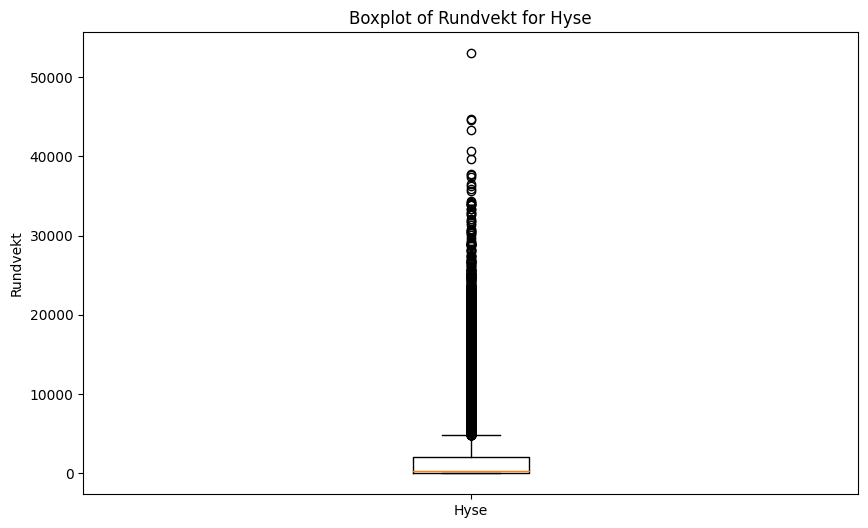

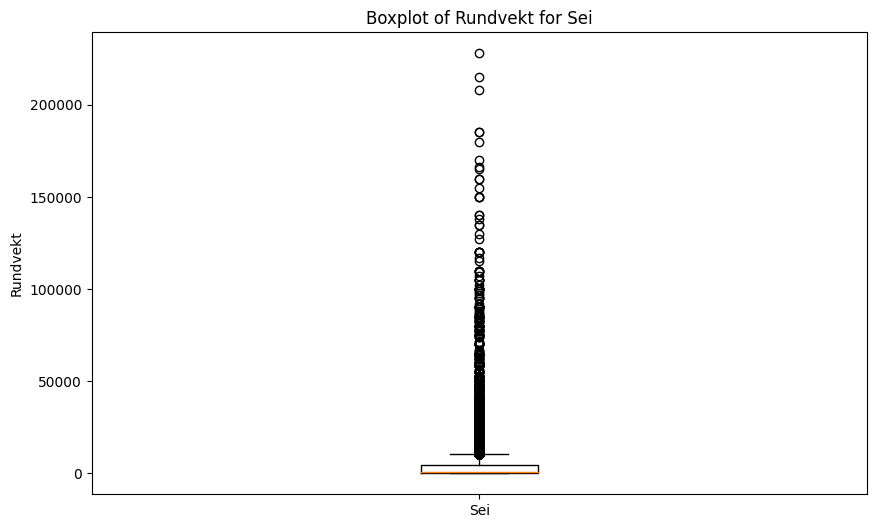

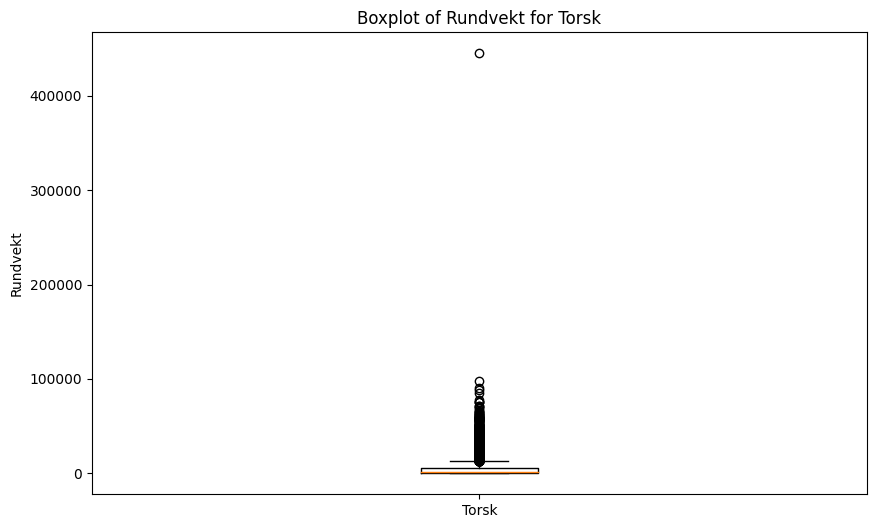

In [26]:
species_grossweight = dataset.groupby("Art FAO")["Rundvekt"].apply(list)

# Define the species of interest
species_of_interest = ["Torsk", "Hyse", "Sei"]

# Filter the aggregated data to include only the species of interest
filtered_species_grossweight = {species: weights for species, weights in species_grossweight.items() if species in species_of_interest}

# Iterate over the filtered Series using .items() for species and their corresponding gross weights
for species, grossweights in filtered_species_grossweight.items():
    plt.figure(figsize=(10, 6))  # Create a new figure for each species

    # Create a boxplot for the species
    plt.boxplot(grossweights)
    plt.title(f'Boxplot of Rundvekt for {species}')
    plt.ylabel('Rundvekt')
    plt.xticks([1], [species])  # Set the x-tick to the name of the current species

    plt.show()  # Show the plot for the current species

Seems like there are many outliers for each species, we believe it will be difficult to outright remove outliers since there are 122 different species and there are probably some species with few outliers while others have a lot. According to "Introduction to Machine Learning with Python: A Guide for Data Scientists" by Andreas C. Müller and Sarah Guido (p.133), employing a RobustScaler offers a strategic solution to this issue. The RobustScaler effectively transforms the data by ignoring points that significantly deviate from the rest, making it particularly suitable for our dataset where outliers are prevalent but their outright removal is impractical."

Checking for NaN values in Gross weight.

In [27]:
print(dataset["Rundvekt"].isna().sum())

0


#### Startområde
Checking for NaN values

In [28]:
print(dataset["Hovedområde start"].isna().sum())

3788


There are only 4000 NaN values, we believe its fine if we drop these.

In [29]:
dataset = dataset.dropna(subset=["Hovedområde start"])

## Supervised learning
In "Introduction to Machine Learning with Python", the book discusses seven different machine learning models: k-Nearest Neighbors (k-NN), linear models, Naive Bayes, decision trees, ensembles of decision trees and neural networks. We will be taking a look at each of these models before determining which model is most appropriate for our problem.

### Picking the Machine learning models
Considering we have 5 features, where 4 of them are categorical and 1 is continuous data, we will have to keep this distribution in mind when picking out models. Our problem is a Binary classification problem, we will therefore not be considering regression models.

#### k-NN
The k-Nearest Neighbors (k-NN) algorithm makes predictions based on the closest data points in the training dataset. k-NN algorithms struggle when there are a lot of features involved, we only have 5 features in our dataset which makes k-NN sound pretty promising.

#### Linear models
Linear models make a prediction using a linear function of the input features. Considering we are working with a classification problem, a logistic regression model seems like a viable and simple option.

#### Naive Bayes
We can rule out Bernoulli naive bayes model because its impossible for us to convert our data to binary, without ending up with 400 features. We can also rule out gaussian since it need all features to be real numbers.

MultinomialNB assumes count data, we would have to change our features such that it represents an integer count. We would have to put a lot of work into feature engineering, which would mean more work when preprocessing.

#### Ensembles of decision trees
"Decision trees are widely used models for classification and regression tasks. Essentially, they learn a hierarchy of if/else questions, leading to a decision."-"Introduction to Machine Learning with Python: A Guide for Data Scientists" by Andreas C. Müller and Sarah Guido (p.70)

Ensembles combines multiple machine learning models, this is to better generalize the data even if each model overfit. this model generates many different trees (which will all overfit), it then uses the average or voting to decide on a value.

Considering we have over 100 features and 300 000 entries, the most logical choice would be to go with gradient boosting. Since gradient boosting prunes to make smaller trees, this will make the model train much faster.  


#### Neural networks
Is a class of machine learning algorithms that works well with large datasets. They consist of layers of interconnected nodes or neurons, where each connection represents a weighted pathway, and nodes process inputs using activation functions to produce outputs.

### Our choices
We will be using the following models for supervised learning; Logistic regression, gradient boosting forest, neural network. Because of the aforementioned reasons we believe they are the most logical considering we are working with a classification problem, and our features consist of many categories.

### Transforming dataset

#### Target variable
We are attempting to predict whether a specific catch is Bycatch and will therefore create a new column to serve as our target variable.

In [30]:
dataset["Is_Bycatch"] = (dataset["Hovedart FAO"] != dataset["Art FAO"])

#### Changing categorical data into numeric data
We have 5 different categorical data, each of the feature has multiple different categories. One hot Encoding is not a viable options due to the sheer amount of categories we are working with. We will be using "cat.codes" to convert them to numeric values. We believe it isn't important to make sure that "Hovedart FAO" and "Art FAO" have the same categorical code due to the fact that we have the "Is_Bycatch" feature that we will use as our target variable.

In [31]:
# Changing categorical data into numeric data using "cat.codes"
dataset["Art FAO"] = dataset["Art FAO"].astype("category")
dataset["Art FAO Codes"] = dataset["Art FAO"].cat.codes

dataset["Lengdegruppe"] = dataset["Lengdegruppe"].astype("category")
dataset["Lengdegruppe Codes"] = dataset["Lengdegruppe"].cat.codes

dataset["Hovedområde start"] = dataset["Hovedområde start"].astype("category")
dataset["Hovedområde start Codes"] = dataset["Hovedområde start"].cat.codes

dataset["Redskap FAO"] = dataset["Redskap FAO"].astype("category")
dataset["Redskap FAO Codes"] = dataset["Redskap FAO"].cat.codes

# Excluding the old features
dataset = dataset[["Art FAO Codes", "Lengdegruppe Codes", "Redskap FAO Codes", "Rundvekt", "Hovedområde start Codes", "Is_Bycatch"]]

#### Train Test Split

In [32]:
from sklearn.model_selection import train_test_split

# Splitting dataset
X = dataset[["Art FAO Codes", "Lengdegruppe Codes", "Redskap FAO Codes", "Rundvekt", "Hovedområde start Codes"]]
y = dataset["Is_Bycatch"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

#### Scaling "Rundvekt"

In [33]:
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

# Scaling only "Rundvekt" and not the others
ct = ColumnTransformer(
    [("scale", RobustScaler(), ["Rundvekt"])],
    remainder='passthrough'
)

# Fitting the scaler to the training set and not the test set to prevent data leakage
X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.transform(X_test)

### Implementation and evaluation
We will be evaluating each model using cross validation and a grid search.

Cross validation is a technique that splits the data repeatedly and trains multiple models, this ensures that we aren't lucky or unlucky with the split of the data. We believe a stratified k-Fold Cross-Validation is the best to use in our case as the difference in entries between the most common fish and the others is large.

Grid search is a technique that improves the model's generalization by tuning its parameters. Running a Grid Search with Cross-Validation will ensure that we get the best possible overview of how well the model performs.

We will be measuring false negatives as a measure of success since we want to reduce the amount of misreporting happening.

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.datasets import make_blobs
from sklearn.pipeline import Pipeline

## Unsupervised Learning

### Preprocessing for Unsupervised Learning

We made a new dataset for unsupervised learning.

In [35]:
# Excluding Is_Bycatch
dataset_unsuper = dataset[["Art FAO Codes", "Lengdegruppe Codes", "Redskap FAO Codes", "Rundvekt", "Hovedområde start Codes"]]

We used the transformed and scaled dataset that we have used in supervised learning. We did robust scaling again to the feature ‘Rundvekt’ for the entire dataset as it was separated by a training set and a test set in the supervised learning step.

In [36]:
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

# Scaling only "Rundvekt" and not the others
ct = ColumnTransformer(
    [("scale", RobustScaler(), ["Rundvekt"])],
    remainder='passthrough'
)

# Fitting the scaler to the training set and not the test set to prevent data leakage
dataset_scaled = ct.fit_transform(dataset_unsuper)


### Picking the Machine Learning Models for Unsupervised Learning

#### Two Kinds of Unsupervised Learning Algorithms


1. Unsupervised Transformations   
This algorithm is an algorithms to create a new representation of data. It is often used for dimensionality reduction or finding the parts or components that make up the data (from the textbook p.131). Those are usually used for visualization or extracting useful features. Thus we believe that it’s not the best algorithm to derive a new information from the given data, what we were trying to do.

2. Clustering Algorithms   
This algorithm makes different groups, which is called ‘clusters’, within a given data. By using clustering, we thought that we could discover new relationships other than bycatch between features that we’ve used in the step of supervised learning.

#### Picking a Clustering Algorithm  
There are three clustering algorithms—k-Means Clustering, Agglomeration Clustering, DBSCAN. There are two points we should consider.

First, our features are mostly categorical features which has been transformed into numeric. This means that the numbers in each categorical features don’t mean continuous values, which makes it impossible to calculate the means of those values for k-Means.

Second, we want to explore the dataset and don’t know how many clusters there will be. However, we should set the number of clusters as a parameter for k-Means and agglomeration clustering.
Thus, we believe that k-Means and agglomeration clustering are not proper algorithms for our dataset and we chose to use DBSCAN for unsupervised learning.

### Clusturing with DBSCAN


There are 2 parameters in DBSCAN: min_samples and eps. Eps defines the maximum distance between two samples to be considered as part of the same neighborhood while min_samples defines the number of samples in a neighborhood for a point to be considered as a core point.

Firstly, we tried to see the change of result by increasing of min_samples generally.

In [37]:
from sklearn.cluster import DBSCAN

#eps = 0.5 (default)
for min in [10, 100, 200, 500, 1000, 10000]:
    print("\nmin_samples={}".format(min))
    dbscan = DBSCAN(min_samples=min)
    clusters = dbscan.fit_predict(dataset_unsuper)
    print("Clusters present: {}".format(np.unique(clusters)))
    print("Cluster size:{}".format(np.bincount(clusters+1)))


min_samples=10
Clusters present: [  -1    0    1 ... 3762 3763 3764]
Cluster size:[221012    143     11 ...     10     18     11]

min_samples=100
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25]
Cluster size:[292868    143    104    103    134    199    113    164    106    172
    101    140    106    151    134    100    101    169    134    251
    260    145    102    112    124    134    107]

min_samples=200
Clusters present: [-1  0  1]
Cluster size:[295966    251    260]

min_samples=500
Clusters present: [-1]
Cluster size:[296477]

min_samples=1000
Clusters present: [-1]
Cluster size:[296477]

min_samples=10000
Clusters present: [-1]
Cluster size:[296477]


The result meets our expectation: the increase of min_samples, the decrease of number of clusters. The number of clusters deacreased from 3764 to 0 when min_samples increase from 10 to 500.

As we can see, starting from min_samples = 500, there is no cluster, except cluster -1, which means that all data points will be counted as noise. (For DBSCAN, if the data points are labeled as -1, they are counted as noise) It showed that min_samples = 500 is the maximum value for min_samples in this project.

Moreover, majority of the data points is counted as noise when we examine the results of min_samples = 10 and min_samples = 100. For example, over 75% of data points are treated as noise for min_samples = 10, while over 98% of data points are counted as noise for min_samples = 100. To lessen the size of the noise, we thus attempt to deal with another parameter, eps.

In [38]:
# out of RAM --> cannot run
"""
for eps in [1, 10, 20, 50, 100]:
    print("\neps={}".format(eps))
    print("min_samples={}".format(10))
    dbscan = DBSCAN(eps=eps, min_samples=10)
    clusters = dbscan.fit_predict(dataset_unsuper)
    print("Clusters present: {}".format(np.unique(clusters)))
    print("Cluster size:{}".format(np.bincount(clusters+1)))
"""

'\nfor eps in [1, 10, 20, 50, 100]:\n    print("\neps={}".format(eps))\n    print("min_samples={}".format(10))\n    dbscan = DBSCAN(eps=eps, min_samples=10)\n    clusters = dbscan.fit_predict(dataset_unsuper)\n    print("Clusters present: {}".format(np.unique(clusters)))\n    print("Cluster size:{}".format(np.bincount(clusters+1)))\n'

We looked at the change of the size of noise by increasing eps. However, we cannot run the whole for loop on our computers or on a google colab; it says that 'Your session crashed after using all available RAM' when eps = 20. Therefore, we tried different possible values below 20 for eps.

#### Looking into the Influence of the Values of Parameters

While we were looking at the change of noise, we noticed the size of the biggest cluster dominated the dataset. We believe it would be interesting to plot it out.

To compare the changes of the size of noise more clearly, we also tried to plot a graph to see the trend.

We'll look into how the clustering changes according to the parameter 'eps' while the aprameter 'min_samples' is 10, 100 and 200 individually. Then we'll look into the change according to the min_samples while the eps is fixed with 17.



> min_sampels = 10




eps=1
nmin_samples=10
Clusters present: [  -1    0    1 ... 3935 3936 3937]
Cluster size:[180804    427    119 ...     10     11     14]
Noise size: 180804
Largest cluster size: 1930

eps=3
nmin_samples=10
Clusters present: [  -1    0    1 ... 3294 3295 3296]
Cluster size:[133287    175   5690 ...     11     10     12]
Noise size: 133287
Largest cluster size: 7706

eps=5
nmin_samples=10
Clusters present: [  -1    0    1 ... 2146 2147 2148]
Cluster size:[ 98922 110265     34 ...     11     10     10]
Noise size: 98922
Largest cluster size: 110265

eps=7
nmin_samples=10
Clusters present: [  -1    0    1 ... 1806 1807 1808]
Cluster size:[ 73019 170450     36 ...     10      4      5]
Noise size: 73019
Largest cluster size: 170450

eps=9
nmin_samples=10
Clusters present: [  -1    0    1 ... 1613 1614 1615]
Cluster size:[ 54689 194479     62 ...     10      9      5]
Noise size: 54689
Largest cluster size: 194479

eps=11
nmin_samples=10
Clusters present: [  -1    0    1 ... 1131 1132 1133]

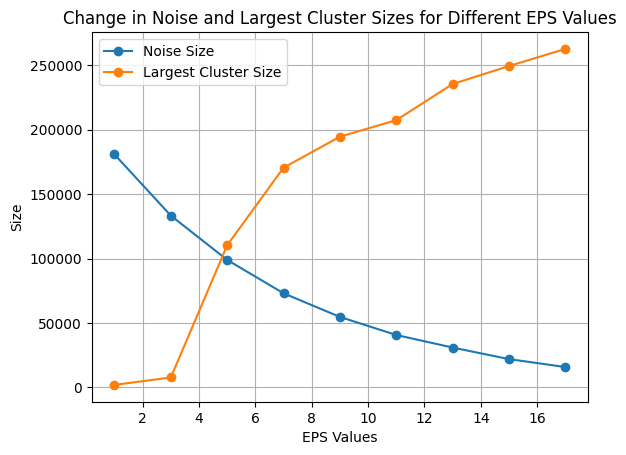

In [39]:
# min_samples = 10

eps_values = [1, 3, 5, 7, 9, 11, 13, 15, 17]
noise_sizes = []
largest_cluster_sizes = []

for eps in eps_values:
    print("\neps={}".format(eps))
    print("nmin_samples={}".format(10))
    dbscan = DBSCAN(eps=eps, min_samples=10)
    clusters = dbscan.fit_predict(dataset_unsuper)
    print("Clusters present: {}".format(np.unique(clusters)))
    cluster_sizes = np.bincount(clusters + 1)
    noise_size = cluster_sizes[0]  # Size of noise is the count of points labeled as -1
    largest_cluster_size = np.max(cluster_sizes[1:]) if len(cluster_sizes) > 1 else 0
    print("Cluster size:{}".format(cluster_sizes))
    print("Noise size: {}".format(noise_size))
    print("Largest cluster size: {}".format(largest_cluster_size))
    noise_sizes.append(noise_size)
    largest_cluster_sizes.append(largest_cluster_size)

# Plotting
plt.plot(eps_values, noise_sizes, marker='o', label='Noise Size')
plt.plot(eps_values, largest_cluster_sizes, marker='o', label='Largest Cluster Size')
plt.title('Change in Noise and Largest Cluster Sizes for Different EPS Values')
plt.xlabel('EPS Values')
plt.ylabel('Size')
plt.legend()
plt.grid(True)
plt.show()


From the graph, we can see that with the increase of eps, the size of noise decreases and the size of largest cluster increase. The size of noise is inversely proportional to the value of eps, while the size of largest cluster is generally proportional to the value of eps.

The size of the largest cluster sharply increased in the beginning, and continued to increase gradually when eps = 7.

Additionally, we can see that starting from eps = 7, the size of noise reduced significantly to below 100000. Thus, next, we would focus on the result beginning with eps = 7.

> min_examples = 100


eps=7
nmin_samples=100
Clusters present: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170]
Cluster size:[167829   1416  76455    190    291   1415    258    787    131    241
    200   4519    176    141    589    435    389    189   3701    182
    318    248    770    192    208    707    198    196    279    178
    260   1769    276    525    3

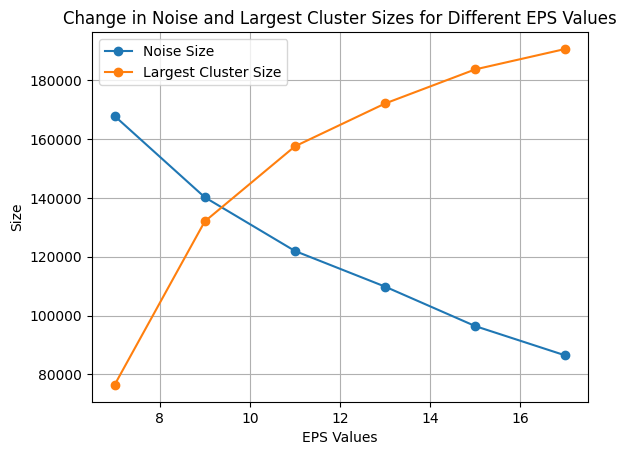

In [40]:
# min_exmaples = 100
min = 100
eps_values = [7, 9, 11, 13, 15, 17]
noise_sizes = []
largest_cluster_sizes = []

for eps in eps_values:
    print("\neps={}".format(eps))
    print("nmin_samples={}".format(min))
    dbscan = DBSCAN(eps=eps, min_samples=min)
    clusters = dbscan.fit_predict(dataset_unsuper)
    print("Clusters present: {}".format(np.unique(clusters)))
    cluster_sizes = np.bincount(clusters + 1)
    noise_size = cluster_sizes[0]  # Size of noise is the count of points labeled as -1
    largest_cluster_size = np.max(cluster_sizes[1:]) if len(cluster_sizes) > 1 else 0
    print("Cluster size:{}".format(cluster_sizes))
    print("Noise size: {}".format(noise_size))
    print("Largest cluster size: {}".format(largest_cluster_size))
    noise_sizes.append(noise_size)
    largest_cluster_sizes.append(largest_cluster_size)

# Plotting
plt.plot(eps_values, noise_sizes, marker='o', label='Noise Size')
plt.plot(eps_values, largest_cluster_sizes, marker='o', label='Largest Cluster Size')
plt.title('Change in Noise and Largest Cluster Sizes for Different EPS Values')
plt.xlabel('EPS Values')
plt.ylabel('Size')
plt.legend()
plt.grid(True)
plt.show()


This graph is generally similar to the previous graph. The only different is that the graph shows a smoother variation in the size of noise and largest cluster size.
Next, we would continue to increase the min_samples to see the difference.

> min_examples = 200


eps=7
nmin_samples=200
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82]
Cluster size:[204895  30504  18596   1513    495    754    638   1226    426    745
    525   2001   4050    550    875    407    410    389   1842    361
    431    429    512    431    710    256    475    653    554    784
    504    309   1532    391    337    292    930    368    402    454
    422    450   1248    243    477    498    339    505    660    308
   1098    278    200    256    251    209    459    323    274    257
    260    191    250    703    311    256    225    200    283    232
    256    222    222    214    210    221    270    217     45    203
    208    237    127    203]
Noise size: 204895
Largest cluster size: 30504

eps=9
nmin_samples=200
Clusters present: [

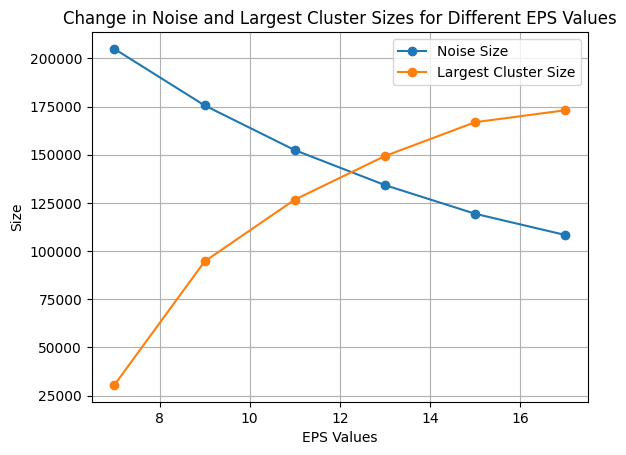

In [41]:
# min_samples = 200
min = 200
eps_values = [7, 9, 11, 13, 15, 17]
noise_sizes = []
largest_cluster_sizes = []

for eps in eps_values:
    print("\neps={}".format(eps))
    print("nmin_samples={}".format(min))
    dbscan = DBSCAN(eps=eps, min_samples=min)
    clusters = dbscan.fit_predict(dataset_unsuper)
    print("Clusters present: {}".format(np.unique(clusters)))
    cluster_sizes = np.bincount(clusters + 1)
    noise_size = cluster_sizes[0]  # Size of noise is the count of points labeled as -1
    largest_cluster_size = np.max(cluster_sizes[1:]) if len(cluster_sizes) > 1 else 0
    print("Cluster size:{}".format(cluster_sizes))
    print("Noise size: {}".format(noise_size))
    print("Largest cluster size: {}".format(largest_cluster_size))
    noise_sizes.append(noise_size)
    largest_cluster_sizes.append(largest_cluster_size)

# Plotting
plt.plot(eps_values, noise_sizes, marker='o', label='Noise Size')
plt.plot(eps_values, largest_cluster_sizes, marker='o', label='Largest Cluster Size')
plt.title('Change in Noise and Largest Cluster Sizes for Different EPS Values')
plt.xlabel('EPS Values')
plt.ylabel('Size')
plt.legend()
plt.grid(True)
plt.show()


When min_sample = 200, regardless of the change of eps, the size of noise remains greater than 100000, which is bad news because it means that 1/3 of the dataset is considered as noise.

Therefore, we assumed that in order to reduce noise, min_samples have to remain below 100 with a larger value of eps.
Thus, we take a look at how the size of noise would change with min_samples.


eps=17
nmin_samples=10
Clusters present: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 

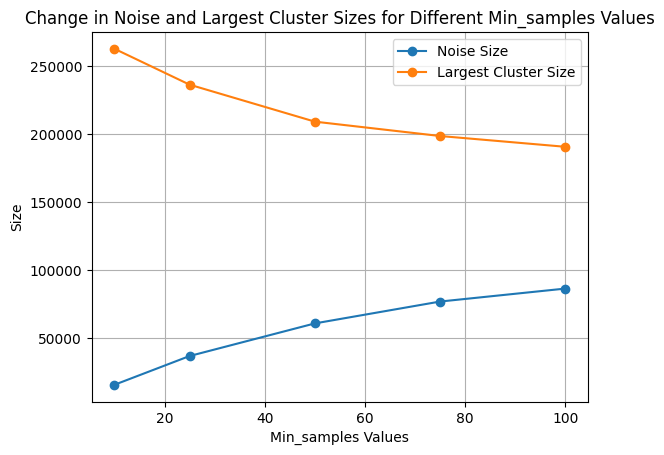

In [42]:
#eps = 17 and min_samples changes
min_values = [10, 25, 50, 75, 100]
eps = 17
noise_sizes = []
largest_cluster_sizes = []

for min in min_values:
    print("\neps={}".format(eps))
    print("nmin_samples={}".format(min))
    dbscan = DBSCAN(eps=eps, min_samples=min)
    clusters = dbscan.fit_predict(dataset_unsuper)
    print("Clusters present: {}".format(np.unique(clusters)))
    cluster_sizes = np.bincount(clusters + 1)
    noise_size = cluster_sizes[0]  # Size of noise is the count of points labeled as -1
    largest_cluster_size = np.max(cluster_sizes[1:]) if len(cluster_sizes) > 1 else 0
    print("Cluster size:{}".format(cluster_sizes))
    print("Noise size: {}".format(noise_size))
    print("Largest cluster size: {}".format(largest_cluster_size))
    noise_sizes.append(noise_size)
    largest_cluster_sizes.append(largest_cluster_size)

# Plotting
plt.plot(min_values, noise_sizes, marker='o', label='Noise Size')
plt.plot(min_values, largest_cluster_sizes, marker='o', label='Largest Cluster Size')
plt.title('Change in Noise and Largest Cluster Sizes for Different Min_samples Values')
plt.xlabel('Min_samples Values')
plt.ylabel('Size')
plt.legend()
plt.grid(True)
plt.show()


It is interesting to see a completely different situation with the previous graphs. The size of noise is proportional to the value of eps, while the size of largest cluster is inversely proportional to the value of eps.

We kept eps unchanged at 17, and tried different min_samples below 100 to see the difference. It showed that the size of noise will increase slightly from 15791 to 86461, while the size of largest cluster steadily decreased from 262598 to 190603.

This graph is actually out of our exceptation since we expected to see a similar graphings like the previous one. We thought it happened because the distribution of the data points is different from what we expected. And since we cannot plot the graph out with PCA (PCA usually work with Itcontinuous numbers), we know less about the distribution of dataset.

#### Is the Largest Cluster Related to Bycatch?

When we were working with the parameters, we noticed that the largest cluster commonly dominated the dataset, which contained over 2/3 of the data points. Thus, we tried to find out what this cluster stand for.

Firstly, we thought of the bycatch, so we took a look at the number of bycatch and non-bycatch.

In [43]:
# The number of bycatch in the dataset

bycatch = np.sum(dataset["Is_Bycatch"] == 1)
no_bycatch = np.sum(dataset["Is_Bycatch"] == 0)

# 결과 출력
print("Number of bycatch:", bycatch)
print("Number of non-bycatch:", no_bycatch)

Number of bycatch: 203949
Number of non-bycatch: 92528


We can see that the number of bycatch and the size of the largest cluster is quite similar. Thus, we thought they may be related.

Next, we tried to figure out is the largest cluster really related to bycatch.

##### Find a Relationship with Bycatch and Make a Confusion Matrix

We picked min_samples = 50 and eps = 17 as the parameter, as in these parameters, the size of the largest cluster is similar to the number of bycatch and the size of noise is fewer.

>Hypothesis: Data points in the largest cluster is bycatch, while data points in other clusters or noise is non-bycatch.

In [44]:
min = 50
eps = 17
print("\neps={}".format(eps))
print("min_samples={}".format(min))
dbscan = DBSCAN(eps=eps, min_samples=min)
clusters = dbscan.fit_predict(dataset_unsuper)
print("Clusters present: {}".format(np.unique(clusters)))
print("Cluster size:{}".format(np.bincount(clusters+1)))


eps=17
min_samples=50
Clusters present: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140]
Cluster size:[ 60875 209072    518   1154    895    624    128   2436    261    537
    538    935    156    712    197    302    503    646    121    123
    549    197    298    107    142    771    236     79    136     64
    119    204    179     98    137    205    472     50    123    443
    121    360     99    123    201    147    225    258    146    168
    102    192

For min_samples = 50 and eps = 17, cluster [0] is the largest cluster with 209072 points. 60875 points are classified as noise.

In [45]:
dataset["Cluster"] = clusters

In [46]:
# Creating an infusion matrix

import pandas as pd

dataset["correct_match"] = None
for index, row in dataset.iterrows():
    if row["Cluster"] == 0 and row["Is_Bycatch"] == 1:     # TT
        dataset.at[index, "correct_match"] = 1
    elif row["Cluster"] != 0 and row["Is_Bycatch"] == 0:   # FF
        dataset.at[index, "correct_match"] = 2
    elif  row["Cluster"] == 0 and row["Is_Bycatch"] == 0:  # TF
        dataset.at[index, "correct_match"] = 3
    elif  row["Cluster"] != 0 and row["Is_Bycatch"] == 1:  # FT
        dataset.at[index, "correct_match"] = 4


In [47]:
TT = np.sum(dataset["correct_match"] == 1)
FF = np.sum(dataset["correct_match"] == 2)
TF = np.sum(dataset["correct_match"] == 3)
FT = np.sum(dataset["correct_match"] == 4)

# Confusion matrix
print("Number of largest cluster and bycatch:", TT)
print("Number of largest cluster and non-bycatch:", TF)
print("Number of other clusters and bycatch:", FT)
print("Number of other clusters and non-bycatch:", FF)
print("Accuracy: {}".format((TT+FF)/(TT+TF+FT+FF)))

Number of largest cluster and bycatch: 182376
Number of largest cluster and non-bycatch: 26696
Number of other clusters and bycatch: 21573
Number of other clusters and non-bycatch: 65832
Accuracy: 0.837191417884018


The accuracy shows how much the largest cluster and the other clusters including noise match to bycatch and non-bycatch respectively.

According to the outcome, it can be said that the largest cluster can be considered as bycatch and the other groups (the other clusters and noise)  can be interpreted as non-bycatch in the accuracy of 83.7%.

#### Reflection on Unsupervised Learning


We have done a clustering on the data using DBSCAN algorithm, which doesn't need the number of clusters.

To find suitable parameters of DBSCAN, we have run DBSCAN with different values of parameters, eps and min_example. In this step, we found that


- there is a large number of noise.
- increasing eps parameter reduces the size of noise, but the computer RAM is run out of it if we run, so we could not reduce it dramatically; still we have figured out it is getting decreasing.
- increasing min_samples parameter reduces the number of clusters. We have got 2 clusters when the min_samples is 200 with the default eps (0.5).
- when eps is large, increasing min_samples parameter increases the number of noise.

Additionally, we have tried to find a relationship between the result of clustering and those of supervised learning, where we have discovered whether each data point is bycatch or not. We found it intriguing to observe that with numerous clusters, evaluating the algorithm became challenging. This was partly because we discovered similarities in the size of the largest cluster and the group of bycatch. Moreover, the features we employed for clustering were identical to those used to identify bycatch.

Through this process, we have concluded that the largest cluster represents bycatch, while the remaining clusters, including the noise, do not, with an accuracy of 83.7%.